# OpenVINO example with Squeezenet Model

This notebook illustrates how you can serve [OpenVINO](https://software.intel.com/en-us/openvino-toolkit) optimized models for Imagenet with Seldon Core.

![car](car.png)

Prerequisites:
        
   * ```pip install seldon-core```
   
To run all of the notebook successfully you will need to start it with
```
jupyter notebook --NotebookApp.iopub_data_rate_limit=100000000
```

## Download Squeezenet Model

We will download a pre-trained and optimized model for OpenVINO CPU into a local folder.

In [1]:
!mkdir -p models/squeezenet/1 && \
    wget -O models/squeezenet/1/squeezenet1.1.xml https://s3-eu-west-1.amazonaws.com/seldon-public/openvino-squeeznet-model/squeezenet1.1.xml && \
    wget -O models/squeezenet/1/squeezenet1.1.mapping https://s3-eu-west-1.amazonaws.com/seldon-public/openvino-squeeznet-model/squeezenet1.1.mapping && \
    wget -O models/squeezenet/1/squeezenet1.1.bin https://s3-eu-west-1.amazonaws.com/seldon-public/openvino-squeeznet-model/squeezenet1.1.bin 

--2019-04-24 13:28:04--  https://s3-eu-west-1.amazonaws.com/seldon-public/openvino-squeeznet-model/squeezenet1.1.xml
Resolving s3-eu-west-1.amazonaws.com (s3-eu-west-1.amazonaws.com)... 52.218.105.2
Connecting to s3-eu-west-1.amazonaws.com (s3-eu-west-1.amazonaws.com)|52.218.105.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 37345 (36K) [text/xml]
Saving to: ‘models/squeezenet/1/squeezenet1.1.xml’

models/squeezenet/1 100%[===================>]  36.47K  --.-KB/s    in 0.01s   

2019-04-24 13:28:04 (2.53 MB/s) - ‘models/squeezenet/1/squeezenet1.1.xml’ saved [37345/37345]

--2019-04-24 13:28:04--  https://s3-eu-west-1.amazonaws.com/seldon-public/openvino-squeeznet-model/squeezenet1.1.mapping
Resolving s3-eu-west-1.amazonaws.com (s3-eu-west-1.amazonaws.com)... 52.218.105.2
Connecting to s3-eu-west-1.amazonaws.com (s3-eu-west-1.amazonaws.com)|52.218.105.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9318 (9.1K) [binary/octet-stream]

## Run Seldon Core on Minikube

**The example below assumes Minikube 0.30.0 installed**

In [2]:
!minikube start --memory 4096 --disk-size 20g --extra-config=apiserver.authorization-mode=RBAC

Starting local Kubernetes v1.10.0 cluster...
Starting VM...
Getting VM IP address...
Moving files into cluster...
Setting up certs...
Connecting to cluster...
Setting up kubeconfig...
Starting cluster components...
Kubectl is now configured to use the cluster.
Loading cached images from config file.


## Setup Seldon Core

Follow the instructions to [Setup Cluster](../../seldon_core_setup.ipynb#Setup-Cluster) with [Ambassador Ingress](../../seldon_core_setup.ipynb#Ambassador) and [Install Seldon Core](../../seldon_core_setup.ipynb#Install-Seldon-Core).

## Mount local folder onto minikube for HostPath
Run in the current folder:
```
minikube mount ./models:/opt/ml
```

This will allow the model folder containing the Squeezenet model to be accessed. For production deployments you would use a NFS volume.

## Deploy Seldon Intel OpenVINO Graph

In [12]:
!helm install openvino-squeezenet ../../../helm-charts/seldon-openvino \
    --set openvino.model.path=/opt/ml/squeezenet \
    --set openvino.model.name=squeezenet1.1 \
    --set openvino.model.input=data \
    --set openvino.model.output=prob 

NAME:   openvino-squeezenet
LAST DEPLOYED: Wed Apr 24 14:34:01 2019
NAMESPACE: seldon
STATUS: DEPLOYED

RESOURCES:
==> v1/PersistentVolume
NAME          CAPACITY  ACCESS MODES  RECLAIM POLICY  STATUS  CLAIM                   STORAGECLASS  REASON  AGE
hostpath-pvc  1Gi       RWO           Retain          Bound   seldon/model-store-pvc  manual        1s

==> v1/PersistentVolumeClaim
NAME             STATUS  VOLUME        CAPACITY  ACCESS MODES  STORAGECLASS  AGE
model-store-pvc  Bound   hostpath-pvc  1Gi       RWO           manual        1s

==> v1alpha2/SeldonDeployment
NAME            AGE
openvino-model  1s




In [13]:
!helm template openvino-squeezenet ../../../helm-charts/seldon-openvino \
    --set openvino.model.path=/opt/ml/squeezenet \
    --set openvino.model.name=squeezenet1.1 \
    --set openvino.model.input=data \
    --set openvino.model.output=prob | pygmentize -l json

---
# Source: seldon-openvino/templates/hostPath.json

{
    "kind": "PersistentVolume",
    "apiVersion": "v1",
    "metadata": {
        "name": "hostpath-pvc"
    },
    "spec": {
        "capacity": {
            "storage": "1Gi"
        },
        "hostPath": {
            "path": "/opt/ml",
            "type": ""
        },
        "accessModes": [
            "ReadWriteOnce"
        ],
        "persistentVolumeReclaimPolicy": "Retain",
        "storageClassName": "manual"
    }
}

---
# Source: seldon-openvino/templates/openvino_deployment.json
{
    "apiVersion": "machinelearning.seldon.io/v1alpha2",
    "kind": "SeldonDeployment",
    "metadata": {
        "labels": {
            "app": "seldon"
        },
        "name": "openvino-model",
	"namespace": "seldon"	
    },
    "spec": {
        "name": "openvino",
        "predictors": [
            {
                "componentSpecs": [{
                    "spec": {
                        "containers": [
                       

In [15]:
!kubectl rollout status deploy/openvino-openvino-9740a00 

deployment "openvino-openvino-9740a00" successfully rolled out


## Serve Requests

**Ensure you port forward ambassador:**

```
kubectl port-forward $(kubectl get pods -n seldon -l app.kubernetes.io/name=ambassador -o jsonpath='{.items[0].metadata.name}') -n seldon 8003:8080
```

(1, 3, 227, 227)
	 0 sports car, sport car


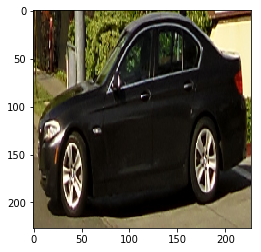

In [17]:
%matplotlib inline
import numpy as np
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
from keras.preprocessing import image
import sys
import json
import matplotlib.pyplot as plt
from seldon_core.seldon_client import SeldonClient

def getImage(path):
    img = image.load_img(path, target_size=(227, 227))
    x = image.img_to_array(img)
    plt.imshow(x/255.)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

X = getImage("car.png")
X = X.transpose((0,3,1,2))
print(X.shape)

sc = SeldonClient(deployment_name="openvino-model",namespace="seldon")

response = sc.predict(gateway="ambassador",transport="rest",data=X)

result = response.response.data.tensor.values
    
result = np.array(result)
result = result.reshape(1,1000)

with open('imagenet_classes.json') as f:
    cnames = eval(f.read())

    for i in range(result.shape[0]):
        single_result = result[[i],...]
        ma = np.argmax(single_result)
        print("\t",i, cnames[ma])
